## Text Extraction and Image processing

In [2]:
# importing libraries
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import image_to_string
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract" # set tesseract path
from PIL import Image
import cv2
import os
from matplotlib import pyplot as plt
import string
from PIL import ImageFilter

poppler_path = r'C:\Program Files\poppler-0.68.0\bin' # setting poppler path
# pages to load
fp = 1
lp = 1
# set the folder name
name = 'test'

In [3]:
from pdf2image import convert_from_path

# converting image based pdf to images
def pdf_image(file, fp, lp):
    return convert_from_path(file, 500, first_page=fp, last_page=lp, fmt='png', 
                          poppler_path=poppler_path)
# gaussian blurring
def gaussian_blur(image):
    gblur = cv2.GaussianBlur(image,(5,5),0)
    return gblur

In [4]:
# correcting skewness
def skew_correct_v2(image):
    
    neg = 255 - image  # get negative image
    angle_counter = 0 # number of angles
    angle = 0.0 # collects sum of angles
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to gray scale
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 15) # thresholding
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20)) # creating a kernel
    dilate = cv2.dilate(thresh,kernel,iterations = 2) 
    
    minLineLength = 1000
    maxLineGap = 250
    lines = cv2.HoughLinesP(thresh,1,np.pi/180,200,minLineLength=500,maxLineGap=20) # calculate houghlines to get orientation
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)
         # calculate the angle (in radians)
        this_angle = np.arctan2(y2 - y1, x2 - x1)
        if this_angle and abs(this_angle) <= 10:
            # filtered zero degree and outliers
            angle += this_angle
            angle_counter += 1

    # the skew is calculated of the mean of the total angles
    if angle == 0 or angle_counter == 0:
        return 0
    skew = np.rad2deg(angle / angle_counter)
    show_scaled("image", image)
    return skew # return angle of rotation
    
# rotating images    
def rotate(image, angle):
    rows, cols, c = image.shape
    rot_mat = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1.0)
    result = cv2.warpAffine(image,
                            rot_mat,
                            (cols, rows),
                            flags=cv2.INTER_CUBIC,
                            borderMode=cv2.BORDER_CONSTANT,
                            borderValue=(255, 255, 255))
    return result

In [5]:
#show image after scaling
scale = 5
def show_scaled(name, img):
    try:
        h, w  = img.shape
    except ValueError:
        h, w, _  = img.shape
    cv2.imshow(name, cv2.resize(img, (w // scale, h // scale)))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [6]:
# transforming image
def image_transformation(image):
    #converting image into gray scale image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    # converting it to binary image by Thresholding
    # black and white, and inverted, because white pixels are treated as objects in contour detection
    threshold_img = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 15)
    # display image
    #show_scaled('threshold image', threshold_img)
    
    # using a kernel that is wide enough to connect characters but not text blocks, and tall enough to connect lines.
    #create a structuring element in the shape of rect - 8 x 8
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))
    #Closing is reverse of Opening, Dilation followed by Erosion.
    #It is useful in closing small holes inside the foreground objects, or small black points on the object.
    closing = cv2.morphologyEx(threshold_img, cv2.MORPH_CLOSE, kernel)
    #Dilation = expanding the pixels based on neighboring pixels
    dilate = cv2.dilate(threshold_img,kernel,iterations = 2)
    # display image
    #show_scaled('Dilated', dilate)
    return dilate

In [7]:
# find contours and textblocks in image
def find_contours(image):
    im2 = image.copy()
    dilate = image_transformation(im2)
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    i = 1 # using a count
    mask = np.zeros(image.shape, dtype=np.uint8) # create an empty masking array with same size as the original image
    masks = [] # array for saving all the masked sections of the image
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt) # construct a bounding rectangle around the contours
        aspect_ratio = w / float(h)
        area = cv2.contourArea(cnt) # contour area 
        if area > 4000 and aspect_ratio > .5:  # check and remove noise
            mask[y:y+h, x:x+w] = image[y:y+h, x:x+w] # mask the area detected by contours
            masks.append(image[y:y+h, x:x+w]) 
            cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2) # build a rectangle over the image based on contours
            cv2.putText(im2,str(i),(x+w+10,y+h),0,1,(0,255,0)) # labelling the contours
            i= i+1
    # writing the contoured and masked image to file
    cv2.imwrite("trial/{0}.png".format(name), im2)
    cv2.imwrite("trial/{0}_mask.png".format(name), mask)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()
    data =  []
    masks.reverse()
    for mask in masks:
        data.append(pytesseract.image_to_string(mask, lang='eng', config='--psm 6'))
   # print(data)
    return data
    #return im2

In [8]:
pages = pdf_image('diagnosis reports/p1p2.pdf', fp, lp)
for page in pages:
    image = np.array(page) 
    im = image.copy()
    dst = cv2.fastNlMeansDenoising(image,None,10,7,21)
    skew = skew_correct_v2(dst)
    print(skew)
    #show_scaled("before",im)
    skew_corr = rotate(image, skew)
    #show_scaled("after",skew_corr)
    blur = gaussian_blur(skew_corr)
    #show_scaled("final",blur)
    data = find_contours(blur)

0


In [9]:
data # preview data

['SPECIMEN(S) RECEIVED\nA’ Adhesion, pelvic\n6B: Ovanan cyst, left\nC: Ovary, portion of right\n\x0c',
 'CLINICAL INFORMATION\nEndometriosis\n\x0c',
 '\x0c',
 'FINAL DIAGNOSIS\n(A) Adhesion, pelvic, biopsy:\nMorphologic changes consistent with endometriosis.\n\x0c',
 '(B) Labeled “ovarian cyst, left":\nMesothelial cyst, no ovarian tissue seen.\n\x0c',
 '(C) Right ovary, portion of-\nEndometriosis.\n\x0c',
 "*“*Electronically Signed***\nbt/'8/31/2016 isis E. Shenouda, M.D.\n—  ———— —————————————————————————————————————————————————————————————————————————— ———————————————— — — ———————\n\x0c",
 'bt/8/31/2016\n\x0c',
 'GROSS DESCRIPTION\nReceived in three containers:\n\x0c',
 '(A) Received in formatin labeled “pelvic adhesion” are multiple strips of pale tan to tan-brown soft to firm tissue, the\nlargest measuring 4 x 0.5 x 0.3 cm. All specimens are totally submitted in cassettes (A1-2).\n\x0c',
 '(B) Received in formalin labeled ‘left ovarian cyst" is one irregular portion of pale tan sof

## Text Processing

In [10]:
# text preprocessing
import re
def preprocess(f1):
    text = re.sub('[^A-Za-z0-9.,]+',' ',f1) # using regex to allow only A-Z, a-z, 0-9 and .,
    text = re.sub(' +', ' ', text) # removing 2+ spaces
    text = text.lower() # converting to lower case
    text = text.strip() # remove empty spaces before and after the string
    return text

In [11]:
list(map(preprocess, data)) # map preprocess function to all elements in list 

['specimen s received a adhesion, pelvic 6b ovanan cyst, left c ovary, portion of right',
 'clinical information endometriosis',
 '',
 'final diagnosis a adhesion, pelvic, biopsy morphologic changes consistent with endometriosis.',
 'b labeled ovarian cyst, left mesothelial cyst, no ovarian tissue seen.',
 'c right ovary, portion of endometriosis.',
 'electronically signed bt 8 31 2016 isis e. shenouda, m.d.',
 'bt 8 31 2016',
 'gross description received in three containers',
 'a received in formatin labeled pelvic adhesion are multiple strips of pale tan to tan brown soft to firm tissue, the largest measuring 4 x 0.5 x 0.3 cm. all specimens are totally submitted in cassettes a1 2 .',
 'b received in formalin labeled left ovarian cyst is one irregular portion of pale tan soft tissue measuring 0.2 om. the specimen is sectioned and totally submitted in cassette b1 .',
 '1.1',
 'x08x',
 'c received in formalin labeled portion of right ovary is one portion of pale tan to tan brown soft ti

-------

In [12]:
pages = pdf_image('data/data1.pdf', fp, lp)

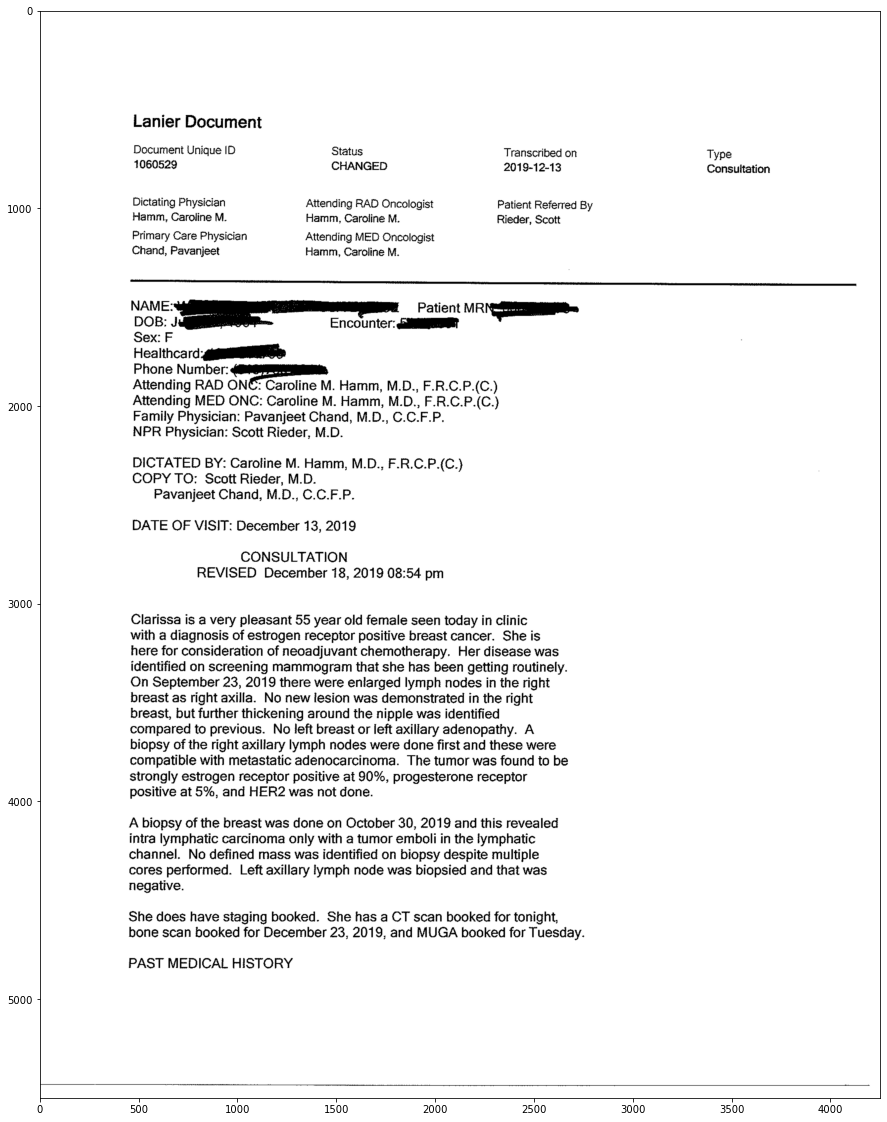

In [13]:
image = np.array(pages[0])

plt.figure(figsize=(30,20))
plt.imshow(image) 
plt.show()  #

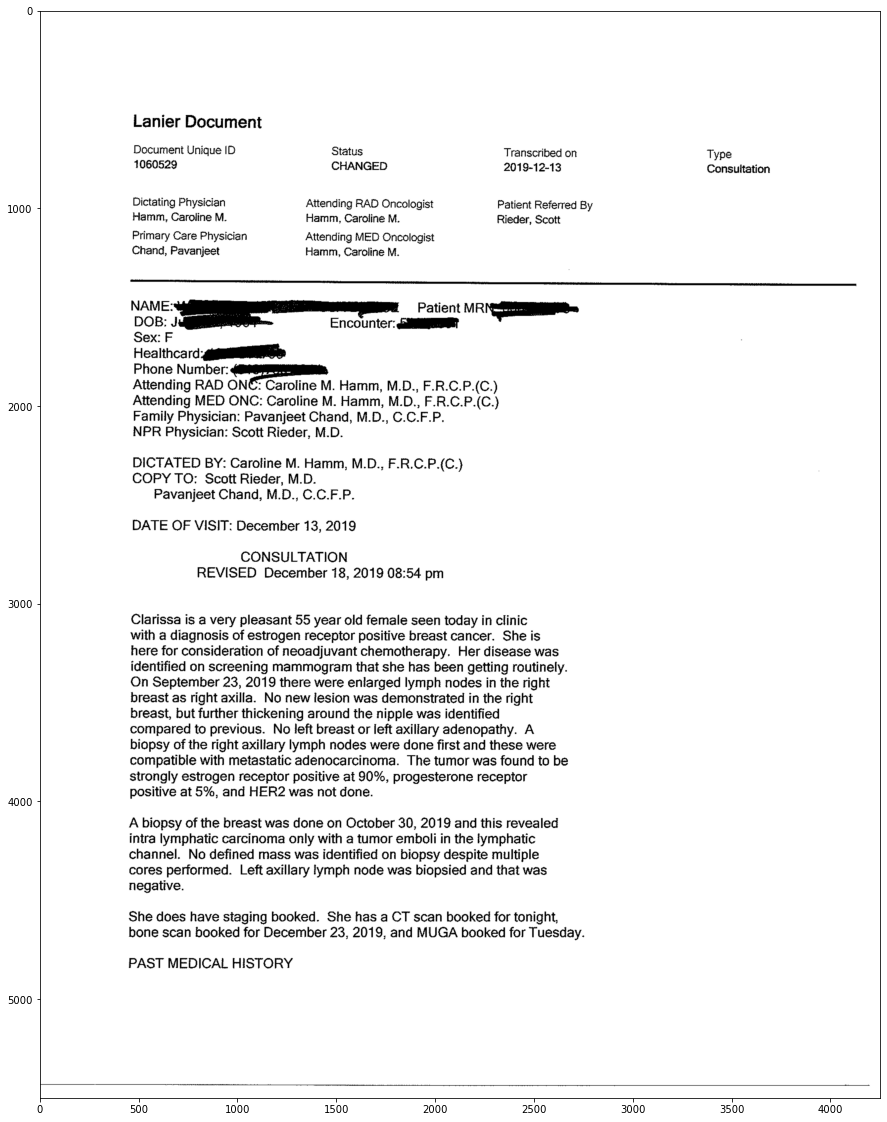

In [14]:
im2 = image.copy()
skew = skew_correct_v2(image)
skew_corr = rotate(im2, skew)
plt.figure(figsize=(30,20))
plt.imshow(skew_corr) 
plt.show()  #

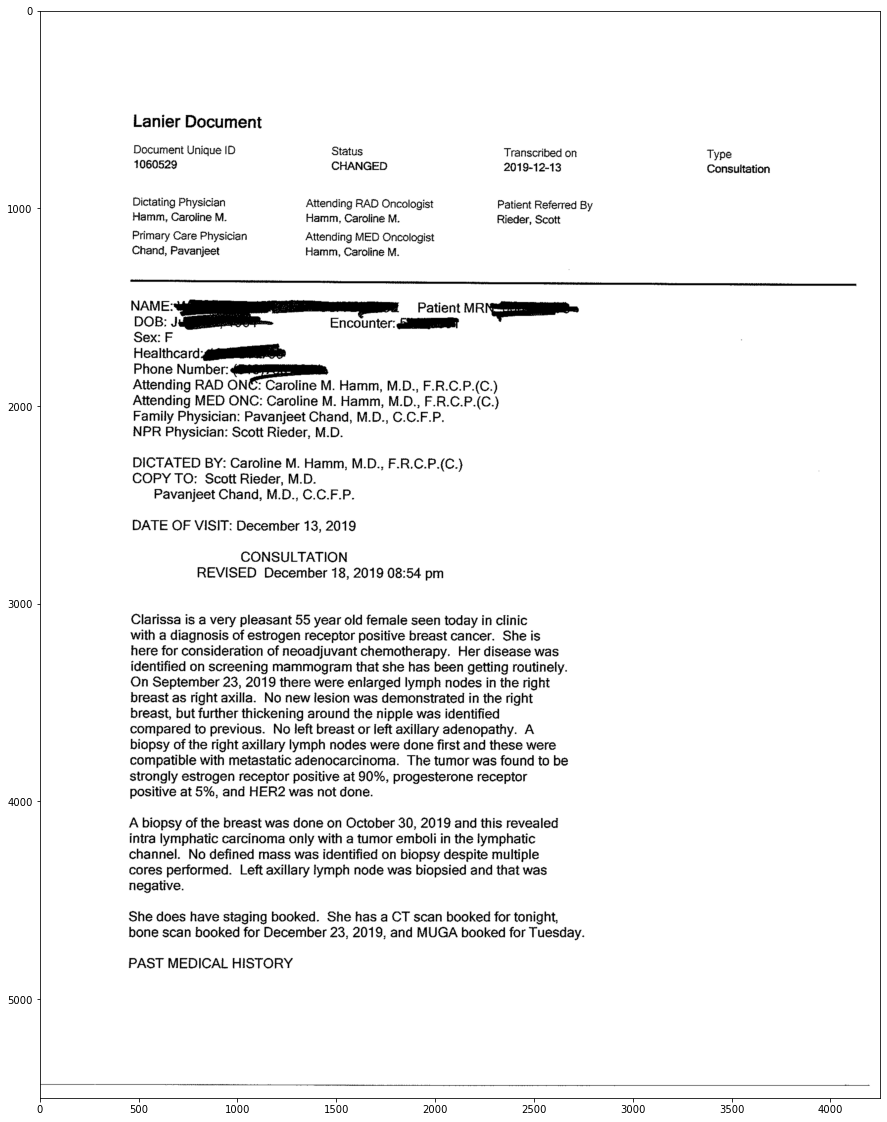

In [15]:
# plt.hist(skew_corr.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k') #calculating histogram
# plt.show()
# Denoising
dst = cv2.fastNlMeansDenoising(skew_corr,None,10,7,21)
plt.figure(figsize=(30,20))
plt.imshow(dst) 
plt.show()

In [16]:
gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

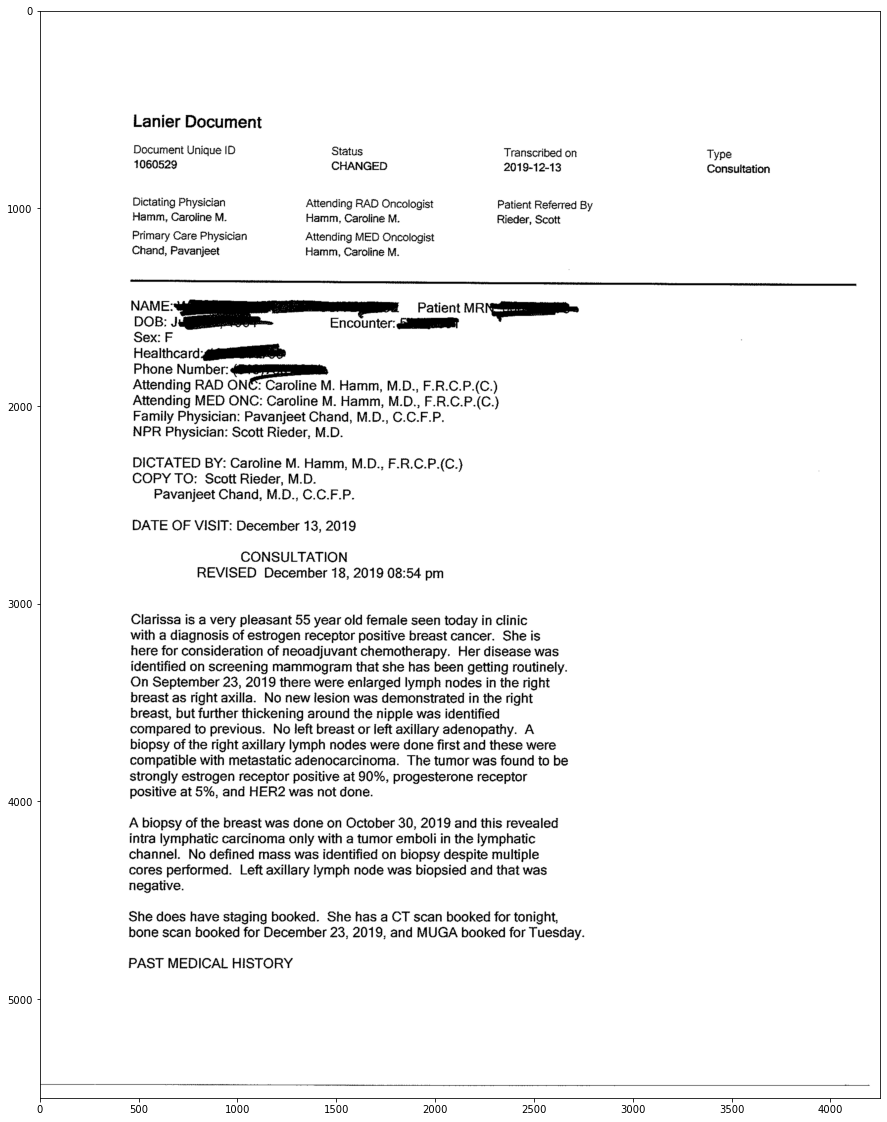

In [17]:
gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
#print(dst.dtype)
result = 255 - opening
plt.figure(figsize=(30,20))
plt.imshow(dst) 
plt.show()


In [18]:
blur = gaussian_blur(dst)
data = find_contours(blur)

In [19]:
data = list(map(preprocess, data))
data

['lanier document',
 'document unique id 1060529',
 'status changed',
 'transcribed on 2019 12 13',
 'type consultation',
 'dictating physician hamm, caroline m.',
 'attending rad oncologist hamm, caroline m.',
 'patient referred by rieder, scott',
 'primary care physician chand, pavanjeet',
 'attending med oncologist hamm, caroline m.',
 'tet gaas sss fgf',
 'a airrmmmmasann sent patient mr dob j encounter sagat sex f healthcard jggaaaaaaaaaaaae phone nelsen attending rad onc caroline m. hamm, m.d., f.r.c.p. c. attending med onc caroline m. hamm, m.d., f.r.c.p. c. family physician pavanjeet chand, m.d., c.c.f.p. npr physician scott rieder, m.d.',
 'dictated by caroline m. hamm, m.d., f.r.c.p. c. copy to scott rieder, m.d. pavanjeet chand, m.d., c.c.f.p.',
 'date of visit december 13, 2019',
 'consultation revised december 18, 2019 08 54 pm',
 'clarissa is a very pleasant 55 year old female seen today in clinic with a diagnosis of estrogen receptor positive breast cancer. she is here f

In [20]:
# spell correct
from textblob import TextBlob
from textblob.en import Spelling 

#training TextBlob with custom data
textToLower = ""

with open("trial/health_2.txt","r") as f1:           # Open our source file
    text = f1.read()                                  # Read the file                 
    textToLower = text.lower()                        # Lower all the capital letters

words = re.findall("[a-z]+", textToLower)             # Find all the words and place them into a list    
oneString = " ".join(words)                           # Join them into one string
pathToFile = "trial/corpus.txt"                      # The path we want to store our stats file at
spelling = Spelling(path = pathToFile)                # Connect the path to the Spelling object
spelling.train(oneString, pathToFile)  

In [21]:
# def autocorrect_merge(txt):
#     data =[]
#     doc = nlp(txt)
#     for token in doc:
#         if token.text !=' ':
#             data.append(str(spelling.suggest(token.text)[0][0]))
#     return data

In [22]:
from nltk.tokenize import word_tokenize, sent_tokenize
# autocorrect function
def autocorrect_merge(txt): 
    final = []
    txt = sent_tokenize(txt)
    if(not isinstance(txt, list)):
        txt = [txt]
#     txt = list(map(sent_tokenize, txt))
    for item in txt:
        text = ''
        txt = word_tokenize(item)
        for i in txt:
            text += ' ' + str(spelling.suggest(i)[0][0])
        final.append(text)
    return final
    

In [23]:
# autocorrection and tokenization
#autocorrect_merge(word_tokenize(data[4]))


In [24]:
# final = []
# txt = data[1]
# txt = sent_tokenize(txt)
# if(not isinstance(txt, list)):
#     txt = [txt]
    
# # for item in txt:
# #     temp = sent_tokenize(item)
# #     # txt = list(map(sent_tokenize, txt))
# #     print(type(temp))
    
    
# for item in txt:   
#     text = ''
#     token = word_tokenize(item)
#     for i in token:
#         text += ' ' + str(spelling.suggest(i)[0][0])
#     final.append(text)
# final

In [25]:
data

['lanier document',
 'document unique id 1060529',
 'status changed',
 'transcribed on 2019 12 13',
 'type consultation',
 'dictating physician hamm, caroline m.',
 'attending rad oncologist hamm, caroline m.',
 'patient referred by rieder, scott',
 'primary care physician chand, pavanjeet',
 'attending med oncologist hamm, caroline m.',
 'tet gaas sss fgf',
 'a airrmmmmasann sent patient mr dob j encounter sagat sex f healthcard jggaaaaaaaaaaaae phone nelsen attending rad onc caroline m. hamm, m.d., f.r.c.p. c. attending med onc caroline m. hamm, m.d., f.r.c.p. c. family physician pavanjeet chand, m.d., c.c.f.p. npr physician scott rieder, m.d.',
 'dictated by caroline m. hamm, m.d., f.r.c.p. c. copy to scott rieder, m.d. pavanjeet chand, m.d., c.c.f.p.',
 'date of visit december 13, 2019',
 'consultation revised december 18, 2019 08 54 pm',
 'clarissa is a very pleasant 55 year old female seen today in clinic with a diagnosis of estrogen receptor positive breast cancer. she is here f

In [26]:


sent=[]
for item in data:
    if(item):
        sent.extend(autocorrect_merge(item))

In [27]:
sent

[' lanier document',
 ' document unique rad 1060529',
 ' status changes',
 ' transcribed pr 2019 12 13',
 ' type consultation',
 ' dictating physician name , caroline m .',
 ' attending rad oncologist name , caroline m .',
 ' patient referred pr rieder , scott',
 ' primary care physician chand , pavanjeet',
 ' attending med oncologist name , caroline m .',
 ' tah mass mass cgy',
 ' a airrmmmmasann lens patient pr dob j encounter sagat med f healthcard jggaaaaaaaaaaaae phone nelsen attending rad out caroline pr name , med , f.r.c.p .',
 ' pr attending med out caroline pr name , med , f.r.c.p .',
 ' pr family physician pavanjeet chand , med , c.c.f.p .',
 ' npr physician scott rieder , med .',
 ' dictated pr caroline pr name , med , f.r.c.p .',
 ' pr cgy tah scott rieder , med .',
 ' pavanjeet chand , med , c.c.f.p .',
 ' date pr visit december 13 , 2019',
 ' consultation revised december 18 , 2019 08 54 pr',
 ' clarissa es a er pleasant 55 er rad female seen today pr clinic with a diagn

--------

In [28]:
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.feature_extraction.text import TfidfVectorizer 
# tfIdfVectorizer=TfidfVectorizer(use_idf=True)
# tfIdf = tfIdfVectorizer.fit_transform(sent)
# df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
# df = df.sort_values('TF-IDF', ascending=False)
# print (df.head(60))
